In [1]:
import numpy as np
import torch
import torch.nn as nn      
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import cv2
from PIL import Image
from pylab import rcParams
rcParams['figure.figsize'] = 5, 5
import tqdm
from numpy import moveaxis
import plotly.graph_objects as go
import scipy.ndimage

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 7, 5)
        self.pool = nn.MaxPool2d(3, 3)
        
        self.dropout = nn.Dropout(p=0.5)
        self.conv2 = nn.Conv2d(7, 10, 5)
        
        
        self.fc1 = nn.Linear(90, 60)
        self.fc2 = nn.Linear(60, 30)
        self.fc3 = nn.Linear(30, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
hunter = Net()
hunter.load_state_dict(torch.load("hunter.pt"))


<All keys matched successfully>

In [70]:
def generate_heatmap(input_tensor, model, kernel_size, stride, thresh_prob, label):
    image = input_tensor
    
    width, height = image.shape[-2], image.shape[-1]
    #setting the output image width and height
    output_height = int(np.ceil((height-kernel_size)/stride))
    output_width = int(np.ceil((width-kernel_size)/stride))
    #create a white image of sizes we defined
    heatmap = torch.zeros((output_width, output_height))
    for h in range(0, height):
        for w in range(0, width):
            h_start = h*stride
            w_start = w*stride
            h_end = min(height, h_start + kernel_size)
            w_end = min(width, w_start + kernel_size)
            if (w_end) >= width or (h_end) >= height:
                continue
            input_image = image.clone().detach()
            
            tensor_slice = input_image[:, :, w_start:w_end, h_start:h_end].squeeze(0)
            
            if 0 in tensor_slice.size():
                continue
            
            sweet_slice = np.moveaxis(tensor_slice.numpy(), 0, 2)
            
            
        
            sweet_slice = cv2.resize(sweet_slice, (50,50))
            

            
            
            sweet_tensor =  torch.from_numpy(np.moveaxis(sweet_slice, 2,0)).unsqueeze(0)
            output = model(sweet_tensor).flatten()
            
            output = torch.softmax(output, dim = 0)[label].item()
            
            if  output > thresh_prob:
                heatmap[w,h] = output*200  # mult
#                 plt.imshow(sweet_slice.astype("uint8"))
#                 plt.show()
                
            else:
                heatmap[w,h] =  0.5 
                
    return heatmap.detach().numpy()

def detect_animal_heatmap(model, image_path, kernel_size, stride, label, threshold_prob):
    
    im = cv2.imread(image_path)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im2 = cv2.resize(im, (int(im.shape[1]/3), int(im.shape[0]/3)))
    plt.imshow(im2)
    plt.show()
   
    im2 = moveaxis(im2, 2, 0)
    
    
    
    input_tensor = torch.from_numpy(im2).unsqueeze(0).float()  ## tensor ready to be fed to nn 
    heatmap = generate_heatmap(input_tensor, model, kernel_size, stride, threshold_prob, label)
    print(heatmap.shape)

    heat_shape = im.shape[:-1][::-1]
    heatmap = cv2.resize(heatmap,heat_shape )
    
    
    heatmap = scipy.ndimage.filters.gaussian_filter(heatmap, sigma = [16,16]) ## smoothen 2d image
    plt.set_cmap("jet_r")

    plt.imshow(heatmap)
    plt.show()

    plt.imsave("heatmap.png", heatmap)
    fin = cv2.addWeighted(cv2.imread(image_path), 0.6,cv2.imread("heatmap.png"),0.5, 0)
#     heatmap = cv2.Canny(cv2.imread("heatmap.png",  cv2.IMREAD_GRAYSCALE),100,10)
    f , axarr = plt.subplots(1,3)
    axarr[0].imshow(im, cmap = "gray")
    axarr[1].imshow(heatmap)
#     axarr[1].colorbar()
    axarr[2].imshow(fin)

    return fin

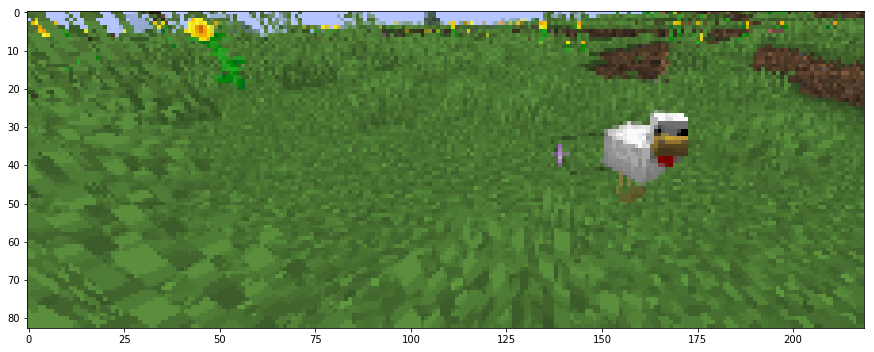

(11, 38)


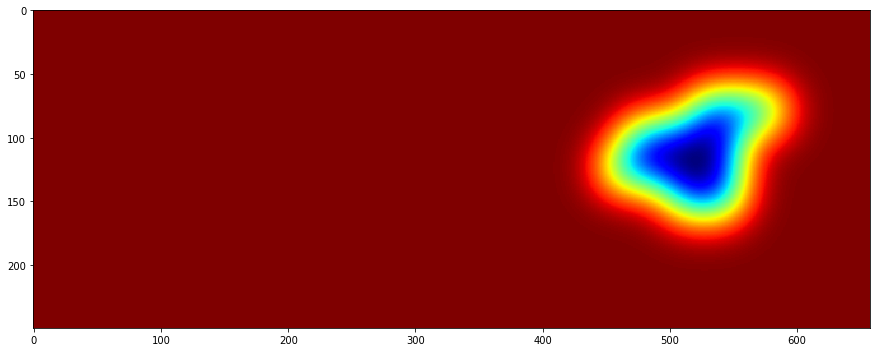

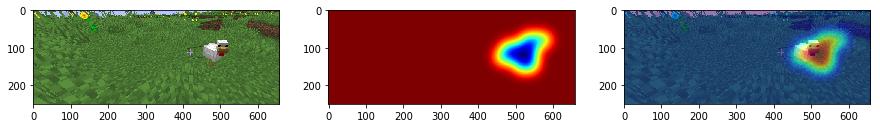

In [6]:
rcParams['figure.figsize'] = 15, 8

foo = detect_animal_heatmap(hunter, "barbecue_boi.png", 30, 5, 0, 0.99)

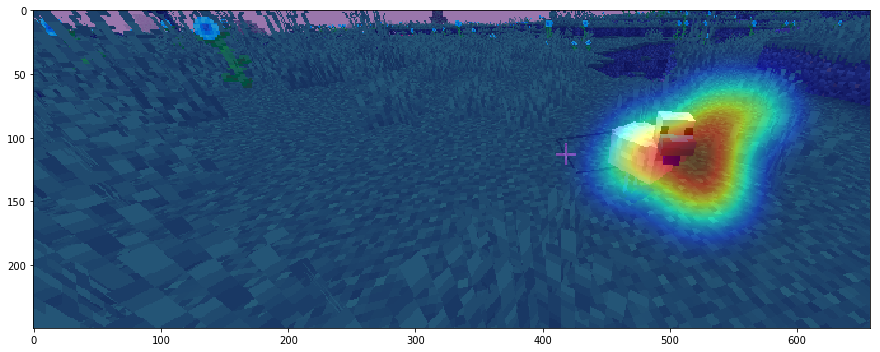

In [7]:
plt.imshow(foo)

In [78]:
def detect_animal_numpy(model, image_np_array, kernel_size, stride, label, threshold_prob):
    
    im = image_np_array
#     im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
#     plt.imshow(im2)
#     plt.show()
   
    im2 = moveaxis(im, 2, 0)
    
    
    
    input_tensor = torch.from_numpy(im2).unsqueeze(0).float()  ## tensor ready to be fed to nn 
    heatmap = generate_heatmap(input_tensor, model, kernel_size, stride, threshold_prob, label)
#     heatmap = cv2.applyColorMap(heatmap_raw.astype(np.uint8), cv2.COLORMAP_JET)
    

    heat_shape = im.shape[:-1][::-1]
    heatmap = cv2.resize(heatmap,heat_shape ).astype(np.float32)
    
    
#     heatmap = scipy.ndimage.filters.gaussian_filter(heatmap, sigma = [16,16]) ## smoothen 2d image

    heatmap = np.stack((heatmap*2, heatmap/2, heatmap/2), axis=-1)  ## force convert image to rgb

    fin = cv2.addWeighted(im.astype(np.float32), 0.5,heatmap,0.5, 0)

    m = fin.astype(np.uint8)

    
    return m

In [87]:
def increase_brightness(img, value=50):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2RGB)
    return img

In [83]:


from mss.linux import MSS as mss
import mss.tools

def screen_cap(top = 0, left = 0, width = 700, height = 520):
    # 800x560 windowed mode
    mon = {"top": top, "left": left, "width": width, "height": height}
    sct = mss.mss()
    
    img = np.array(sct.grab(mon))[...,:3]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    sct.close()
    return img
 

In [89]:

print ("press q to quit")
while True:
    frame = screen_cap(top= 140, height = 410)
    
    frame2 = cv2.resize(frame, (int(frame.shape[1]/3), int(frame.shape[0]/3)))

    frame2 = detect_animal_numpy(hunter,frame2, 60, 16, 0, 0.9)
    frame2 = cv2.resize(frame2, frame.shape[:-1][::-1])
    
    frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)
    
    frame2 = increase_brightness(frame2)

    cv2.imshow("cam",frame2)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        cv2.destroyAllWindows() 
        break


press q to quit
